In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import os

from data_preprocessing import *
from models import SimpleCNN, ResNet
from models.utils import TestCallback
from cutout.cutout import DynamicCutoutLayer, RandomCutoutLayer
from cutout.utils import zero_out, zero_out_batched
# from cutout.mult_cutout import CutOut

2024-04-14 13:27:49.669172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-04-14 10:03:40.448687: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


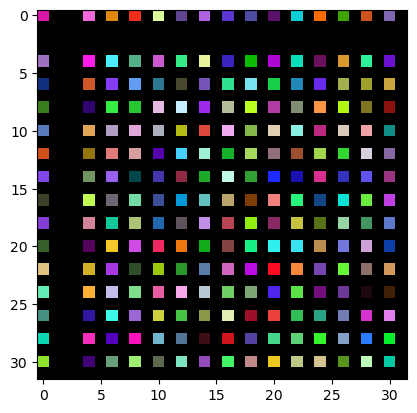

In [2]:
img = tf.ones([32, 32, 3], dtype=tf.float32)
# chess board with 3 channels
img_test = np.zeros((32, 32, 3), dtype=np.uint8)
img_test[::2, ::2] = 255
# img_test[1::2, 1::2] = 255
# img_test[2::2, 2::2] = 255
# img_test[3::2, 3::2] = 255
img_test[1:4,:] = 0
img_test[:,1:4] = 0 
# fill the white square with random color
img_test = img_test * np.random.randint(0, 255, size=(32, 32, 3), dtype=np.uint8)
# convert to tensor
img_test = tf.convert_to_tensor(img_test, dtype=tf.float32) / 255.0
plt.imshow(img_test)
plt.show()

(2, 32, 32, 3)
Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


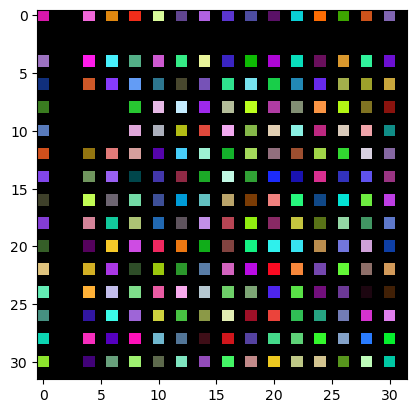

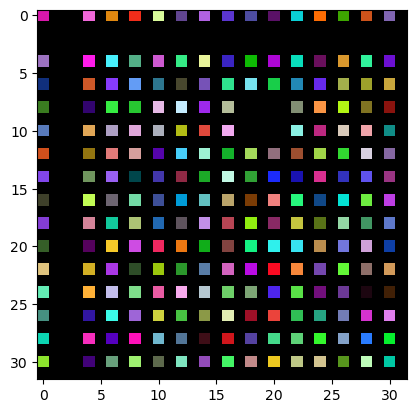

In [3]:
img_test_b = np.expand_dims(img_test, axis=0)
# make a duplicate of the image in the batch
img_test_b = np.concatenate([img_test_b, img_test_b], axis=0)
print(img_test_b.shape)
coords = tf.constant([[10,5], [10,20]])
imgs = zero_out_batched(img_test_b, coords, 4)
plt.imshow(imgs[0])
plt.show()
plt.imshow(imgs[1])
plt.show()

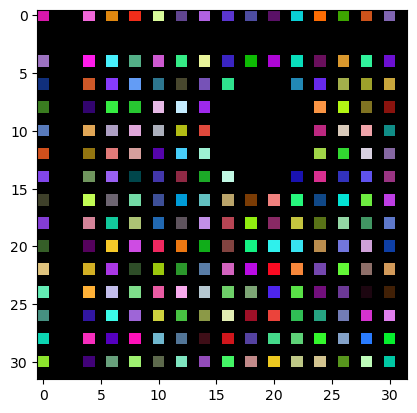

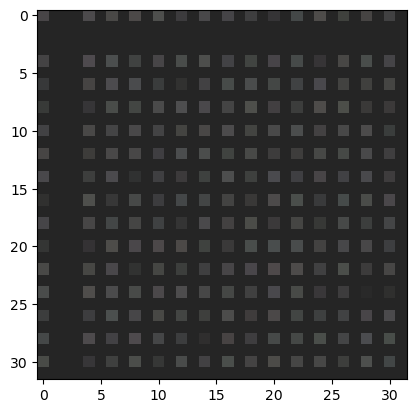

In [4]:
# test random cutout
rnd_cutout = RandomCutoutLayer(mask_size=10, cutout_prob=1, shape='circle')
# rnd_cutout = RandomCutout(mask_size=10, cutout_prob=1, shape='square')
img_cut = rnd_cutout(img_test, training=True)

plt.imshow(img_cut)
plt.show()

# test random augmentations
img_cut = apply_random_augmentations(img_test)
# img_cut = apply_random_augmentations(img_test, fixed_augmentations=[0,1])

plt.imshow(img_cut)
plt.show()

In [2]:
(train_ds, test_ds), info_ds = tfds.load('cifar10', split=['train', 'test'],
                                          as_supervised=True, with_info=True,
                                          shuffle_files=True)
label_names = info_ds.features['label'].names
print(label_names)
# tfds.show_examples(train_ds, info_ds, rows=1, cols=4)
rnd_cutout = RandomCutoutLayer(mask_size=10, cutout_prob=1, shape='square')

# train_data = prepare_dataset(train_ds, "train", cutout_layer=rnd_cutout)
train_data = train_ds.skip(10000).apply(lambda ds: 
                            prepare_dataset(ds, "train", cutout_layer=rnd_cutout))
val_data = train_ds.take(10000).apply(lambda ds: 
                            prepare_dataset(ds, "val"))
# test_data = prepare_dataset(test_ds, "test", cutout_layer=rnd_cutout)
test_data = test_ds.apply(lambda ds:
                          prepare_dataset(ds, "test"))

INFO:absl:Load dataset info from /home/martin/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/home/martin/tensorflow_datasets/cifar10/3.0.2)
2024-04-14 13:28:25.869694: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
INFO:absl:Constructing tf.data.Dataset cifar10 for split ['train', 'test'], from /home/martin/tensorflow_datasets/cifar10/3.0.2


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


2024-04-14 10:03:41.902254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-04-14 10:03:41.902807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-04-14 10:03:43.019286: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: Loop execution was cancelled.
	 [[{{node while/LoopCond/_14}}]]
2024-04-14 10

(32, 32, 3)
(32, 32, 3)


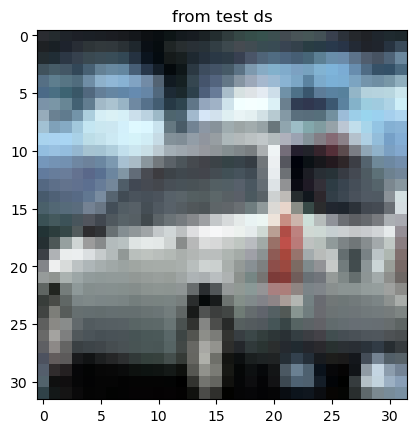

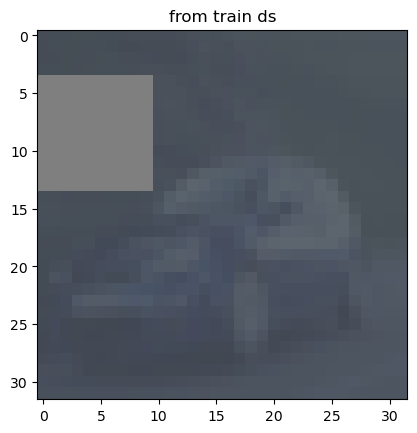

2024-04-14 10:03:43.726147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 10:03:43.726621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-04-14 10:03:44.498610: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

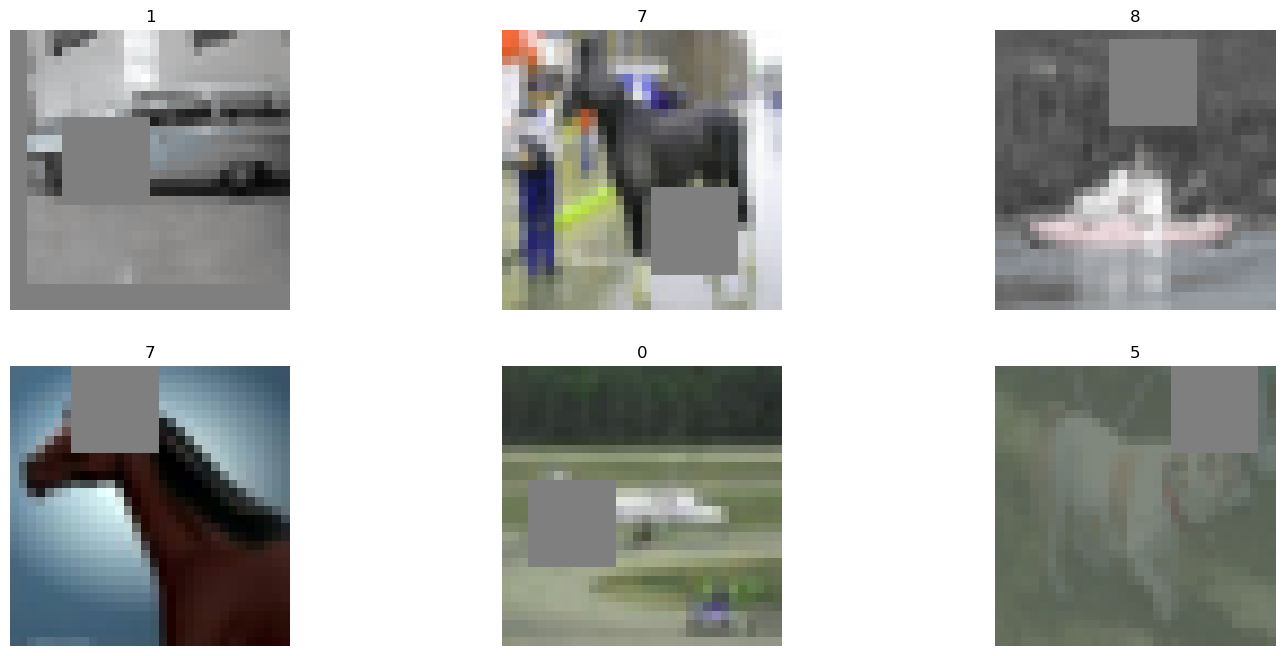

In [6]:
# visualize the training and test data
# rnd_cutout.cutout_size = 20
import matplotlib.pyplot as plt
img_train = iter(train_data.take(1)).next()[0][0]
img_test = iter(test_data.take(1)).next()[0][0]
print(img_test.shape)
print(img_train.shape)
plt.imshow((img_test+1 ) / 2)
plt.title('from test ds')
plt.show()
plt.imshow((img_train+1) / 2)
plt.title('from train ds')
plt.show()

num_samples = 6
max_plots_per_row = 3  
num_columns = min(num_samples, max_plots_per_row)
num_rows = (num_samples + max_plots_per_row - 1) // max_plots_per_row 
fig_width = num_columns * 6
fig_height = num_rows * 4
# create the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(fig_width, fig_height))
# flatten the array of axes
# ensure its an array in case of single sample
axes = np.asarray(axes).flatten()

for i, (image, label) in enumerate(train_data.take(num_samples)):
    axes[i].imshow((image[0] + 1) / 2)
    # set the title to the int of the one-hot encoding
    axes[i].set_title(np.argmax(label[0]))
    axes[i].axis('off')


In [7]:
model = SimpleCNN()
model.build((None, 32, 32, 3))  # Necessary to create the model's weights
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()
train_data = train_data.take(100)
val_ds = train_data.take(10)
train_data = train_data.skip(10)

d = next(iter(train_data))
model.train_step(d)
model.test_step(d)

history = model.fit(train_data, epochs=2, validation_data=val_ds)

# Ensure the directory exists and save the model weights
# os.makedirs('trained_models', exist_ok=True)
# model.save_weights('trained_models/ResNet_cifar10.h5')

2024-04-14 10:03:44.877093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-04-14 10:03:44.877585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-04-14 10:03:45.557520: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): CANCELLED: Loop execution was cancelled.
	 [[{{node while/LoopCond/_14}}]]
2024-04-14 10

Epoch 1/2
90/90 [==============================] - ETA: 0s - loss: 2.1338 - accuracy: 0.2153

2024-04-14 10:03:55.591725: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-14 10:03:55.711497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-04-14 10:03:55.712320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a va

90/90 [==============================] - 10s 102ms/step - loss: 2.1338 - accuracy: 0.2153 - val_loss: 2.0400 - val_accuracy: 0.2500
Epoch 2/2


2024-04-14 10:03:56.792841: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


90/90 [==============================] - ETA: 0s - loss: 1.9904 - accuracy: 0.2812

2024-04-14 10:04:05.062457: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


90/90 [==============================] - 10s 99ms/step - loss: 1.9904 - accuracy: 0.2812 - val_loss: 1.9463 - val_accuracy: 0.2937


2024-04-14 10:04:06.468649: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


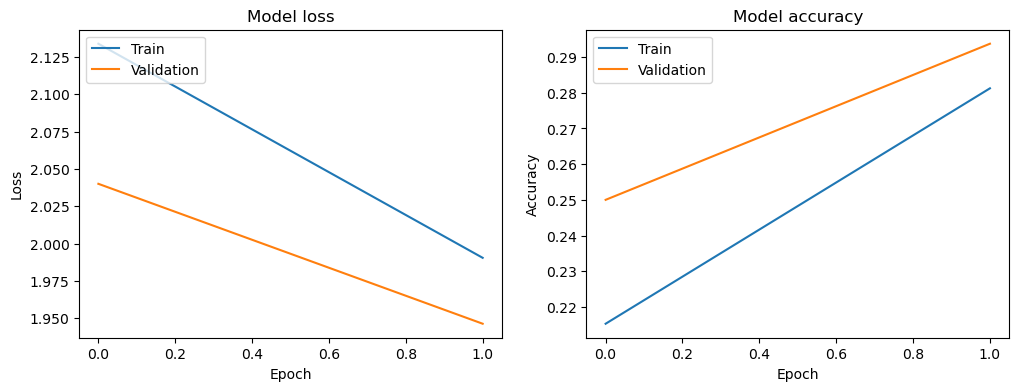

In [10]:
# Plot training & validation loss values
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title('Model loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title('Model accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')

In [ ]:
simple_CNN = SimpleCNN()
simple_CNN.build((None, 32, 32, 3))  # Necessary to create the model's weights
simple_CNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

res_net18 = ResNet((32, 32, 3), 10, type='resnet18')
res_net18.build((None, 32, 32, 3))
res_net18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# res_net18.summary()

res_net34 = ResNet((32, 32, 3), 10, type='resnet34')
res_net34.build((None, 32, 32, 3))
res_net34.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# res_net34.summary()

# test the models
d = next(iter(train_data))
train_step_res = simple_CNN.train_step(d)
test_step_res = simple_CNN.test_step(d)
print(train_step_res)
print(test_step_res)

train_step_res = res_net18.train_step(d)
test_step_res = res_net18.test_step(d)
print(train_step_res)
print(test_step_res)

train_step_res = res_net34.train_step(d)
test_step_res = res_net34.test_step(d)
print(train_step_res)
print(test_step_res)

In [11]:
res = model.evaluate(test_data)
print(type(res))
print(res)

2024-04-14 10:12:06.931227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-04-14 10:12:06.931830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


313/313 [==============================] - 7s 21ms/step - loss: 1.7280 - accuracy: 0.3575
<class 'list'>
[1.7280439138412476, 0.35749998688697815]
